<a href="https://colab.research.google.com/github/Giaco237/loan-default-prediction/blob/main/ETF_XLRE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Introduction – Empirical Analysis of XLRE ETF

In this project, we have chosen to analyze the XLRE ETF (Real Estate Select Sector SPDR Fund) due to its focus on the U.S. real estate sector, a crucial component of diversified investment portfolios. The ETF comprises leading Real Estate Investment Trusts (REITs), which are particularly sensitive to interest rates and economic cycles, making them an interesting subject for risk-return analysis.

The objective of this analysis is to investigate the behavior and relationships between the 30 largest holdings within XLRE over the past 6 months. Specifically, we aim to understand the dynamics of their daily returns, the degree of co-movement (via correlations), and the dominant sources of risk and variance in the portfolio. This exploration provides valuable insights into diversification potential, sectoral clustering, and systemic exposure.

To achieve this, we first calculate daily returns and visualize their correlations using a heatmap. We then apply two powerful dimensionality reduction techniques: **Principal Component Analysis (PCA)** and **Singular Value Decomposition (SVD)**. These methods help us extract the most significant sources of variance across assets, identify patterns of market behavior, and compare structural risk contributions.

In summary, this empirical study seeks to translate raw market data into interpretable components that reveal the internal structure of XLRE, offering a foundation for portfolio construction, risk modeling, and financial decision-making.

#Import library

In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from numpy.linalg import svd

#Step a: Manually define the 30 largest holdings in XLRE

In [16]:
tickers = [
    'AMT', 'PLD', 'CCI', 'PSA', 'SPG', 'DLR', 'WY', 'O', 'EXR',
    'SBAC', 'VTR', 'AVB', 'EQR', 'INVH', 'WELL', 'ARE', 'MAA', 'UDR', 'ESS',
    'REG', 'IRM', 'FRT', 'VNO', 'HST', 'PEAK', 'DRE', 'BXP', 'HIW', 'SLG', 'EQIX'
]
print("Step a: 30 largest XLRE holdings defined.")

Step a: 30 largest XLRE holdings defined.


#Step b: Download 6 months of daily data

In [17]:
print("\nStep b: Downloading 6 months of daily price data...")
data = yf.download(tickers, period='6mo', auto_adjust=True, group_by='ticker')

[                       0%                       ]


Step b: Downloading 6 months of daily price data...


[*********************100%***********************]  30 of 30 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['PEAK', 'DRE']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')


Filter out tickers that failed to download

In [18]:
valid_tickers = [ticker for ticker in tickers if ticker in data.columns.levels[0]]
print(f"\nSuccessfully downloaded data for {len(valid_tickers)} tickers:\n{valid_tickers}")


Successfully downloaded data for 30 tickers:
['AMT', 'PLD', 'CCI', 'PSA', 'SPG', 'DLR', 'WY', 'O', 'EXR', 'SBAC', 'VTR', 'AVB', 'EQR', 'INVH', 'WELL', 'ARE', 'MAA', 'UDR', 'ESS', 'REG', 'IRM', 'FRT', 'VNO', 'HST', 'PEAK', 'DRE', 'BXP', 'HIW', 'SLG', 'EQIX']


Show sample data

In [19]:
sample_ticker = valid_tickers[0]
print(f"\nSample price data for first valid ticker: {sample_ticker}")
print(data[sample_ticker].head())


Sample price data for first valid ticker: AMT
Price             Open        High         Low       Close   Volume
Date                                                               
2025-01-06  178.681998  180.561607  177.009026  177.392822  2262400
2025-01-07  177.264900  178.081700  174.086265  174.351974  2096000
2025-01-08  173.741851  176.467796  172.000000  176.339859  2048300
2025-01-10  170.799404  173.712330  169.766102  170.701004  3539200
2025-01-13  171.881907  174.381500  171.015899  174.125641  2409800


Price chart for top 5 tickers

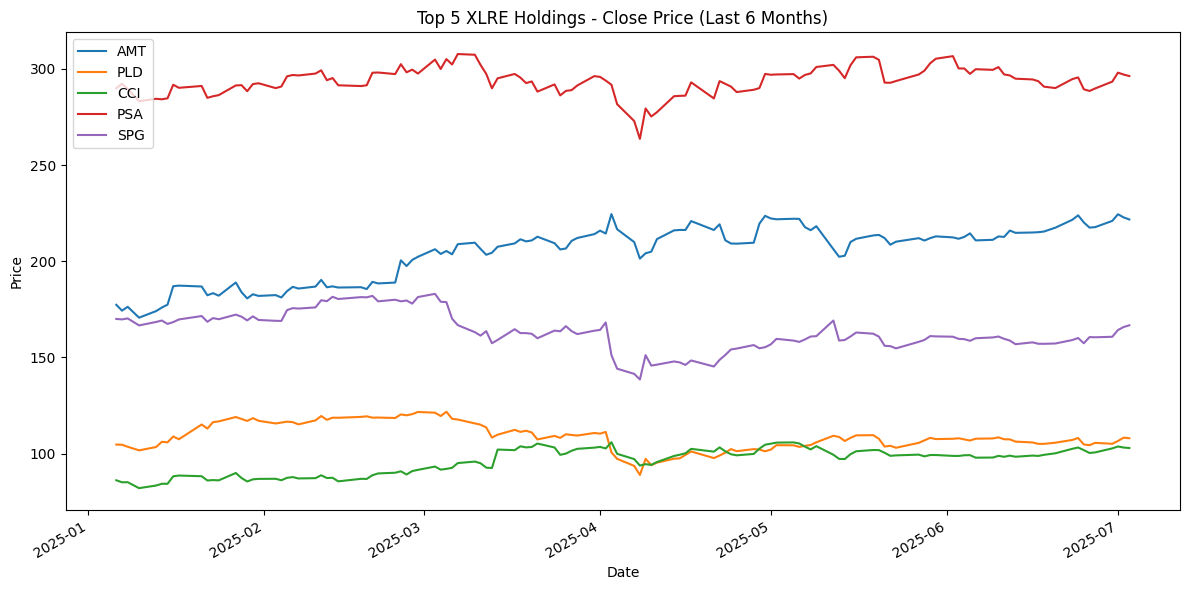

In [20]:
plt.figure(figsize=(12, 6))
for ticker in valid_tickers[:5]:
    data[ticker]['Close'].plot(label=ticker)
plt.title("Top 5 XLRE Holdings - Close Price (Last 6 Months)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

*This line chart shows the closing price trends of the top 5 XLRE holdings over the past 6 months. It allows us to visualize their individual market movements and detect patterns in volatility or outperformance.*

#Step c: Compute daily returns

In [21]:
returns = pd.DataFrame()
for ticker in valid_tickers:
    if 'Close' in data[ticker]:
        series = data[ticker]['Close'].dropna()
        if not series.empty:
            returns[ticker] = series.pct_change()

# Drop rows with all NaNs (due to first NaN after pct_change)
returns.dropna(how='all', inplace=True)

print("\nStep c: Daily returns computed.")
print("Sample daily returns:\n", returns.head())


Step c: Daily returns computed.
Sample daily returns:
                  AMT       PLD       CCI       PSA       SPG       DLR  \
Date                                                                     
2025-01-07 -0.017142 -0.000750 -0.012198  0.008011 -0.001376  0.001559   
2025-01-08  0.011402 -0.010133  0.000457 -0.009189  0.002986  0.005504   
2025-01-10 -0.031977 -0.018104 -0.036228 -0.021898 -0.021352 -0.041632   
2025-01-13  0.020062  0.017183  0.016601  0.004325  0.010763 -0.008192   
2025-01-14  0.010512  0.026099  0.010965 -0.000896  0.004456  0.011459   

                  WY         O       EXR      SBAC  ...       ESS       REG  \
Date                                                ...                       
2025-01-07 -0.017193 -0.004172 -0.000875 -0.015282  ... -0.010008 -0.012943   
2025-01-08 -0.011781  0.000000 -0.002830  0.019501  ...  0.009554 -0.000143   
2025-01-10 -0.014090 -0.015997 -0.008243 -0.034801  ... -0.002714 -0.018817   
2025-01-13  0.050202  0.015483

#Step d: Compute covariance matrix

In [22]:
cov_matrix = returns.cov()
print("\nStep d: Covariance matrix computed.")
print("Covariance matrix (first 5x5 block):\n", cov_matrix.iloc[:5, :5])


Step d: Covariance matrix computed.
Covariance matrix (first 5x5 block):
           AMT       PLD       CCI       PSA       SPG
AMT  0.000317  0.000071  0.000272  0.000147  0.000020
PLD  0.000071  0.000444  0.000092  0.000207  0.000343
CCI  0.000272  0.000092  0.000365  0.000164  0.000049
PSA  0.000147  0.000207  0.000164  0.000212  0.000173
SPG  0.000020  0.000343  0.000049  0.000173  0.000413


Correlation Heatmap of Returns - graph

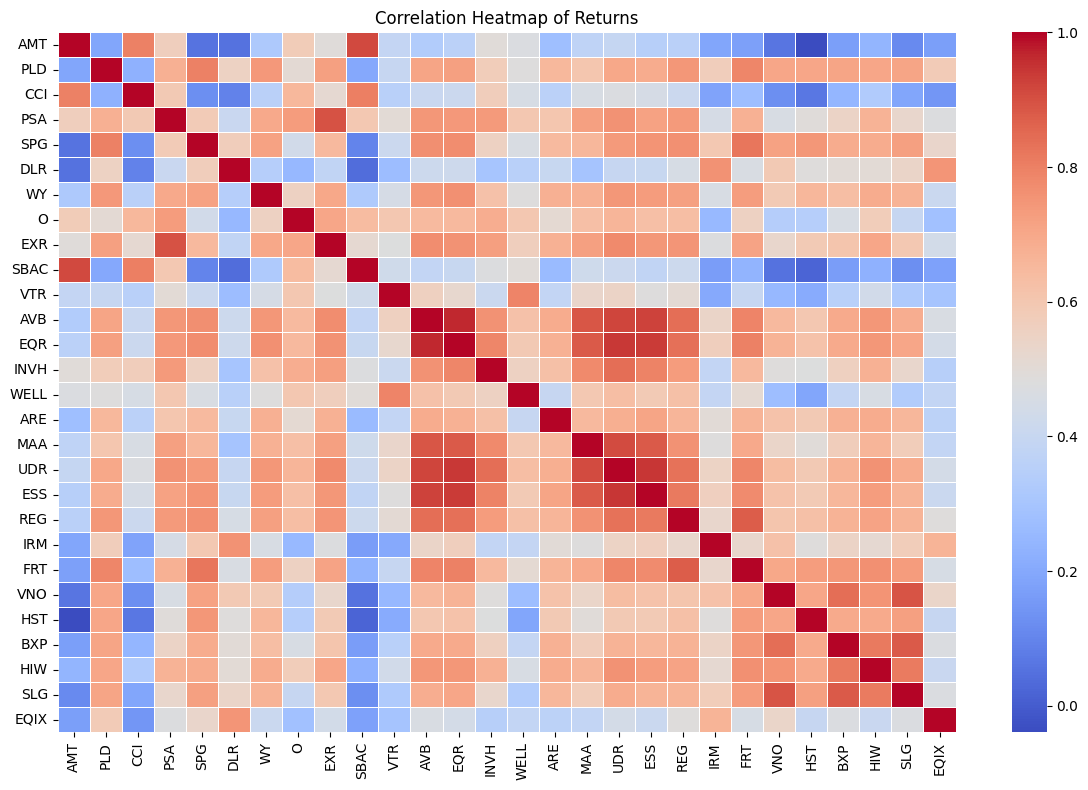

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(returns.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Returns")
plt.tight_layout()
plt.show()

*This heatmap highlights the pairwise correlations between the daily returns of the selected stocks. Strong positive correlations suggest tight sectoral comovements, whereas lower correlations imply diversification potential within the ETF.*

#Step e: Compute PCA

In [24]:
pca = PCA()
pca.fit(returns.dropna())
explained_variance = pca.explained_variance_ratio_
print("\nStep e: PCA computed.")
print("Explained variance ratios:\n", explained_variance[:5])


Step e: PCA computed.
Explained variance ratios:
 [0.58248426 0.125184   0.06215273 0.03943553 0.02693176]


PCA - Explained Variance - graph

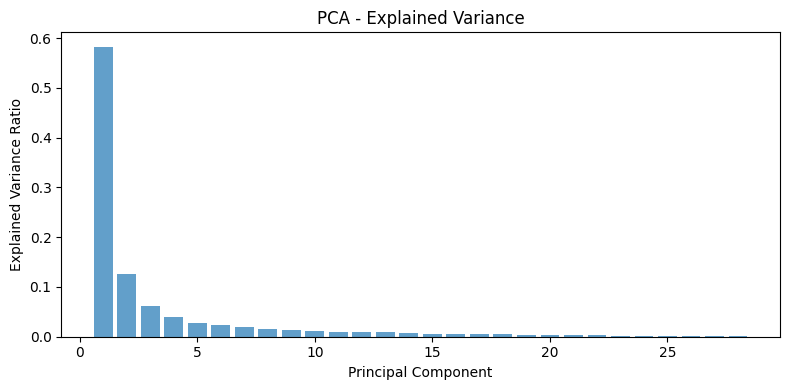

In [25]:
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Explained Variance")
plt.tight_layout()
plt.show()

*The bar plot displays the proportion of variance captured by each principal component. A high variance explained by the first few components indicates that most of the return behavior can be described using fewer dimensions.*

PCA 2D Projection - graph

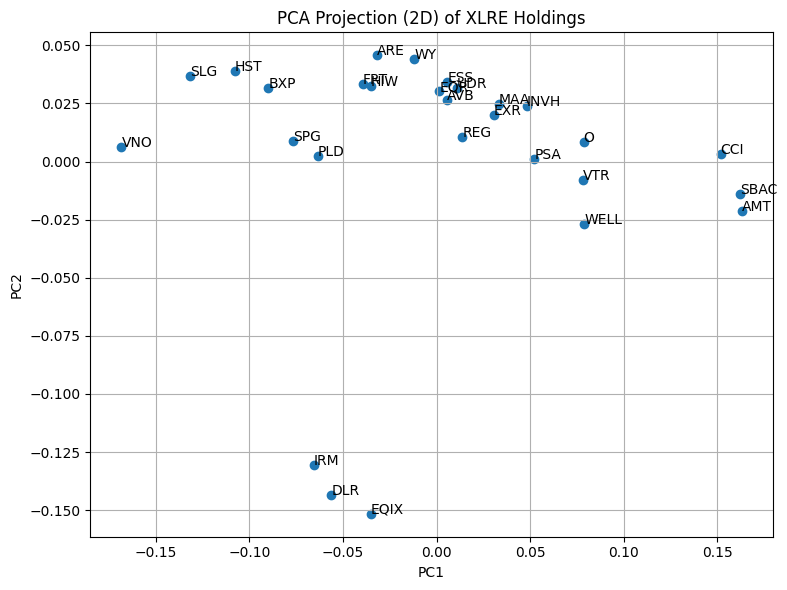

In [26]:
pca_2 = PCA(n_components=2)
pca_result = pca_2.fit_transform(returns.fillna(0).T)
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
for i, txt in enumerate(returns.columns):
    plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]))
plt.title("PCA Projection (2D) of XLRE Holdings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

*This scatter plot shows the projection of all assets in the space of the first two principal components. Assets that are positioned close together in this space exhibit similar return patterns, suggesting common exposure to underlying risk factors.*

#Step f: Compute SVD

In [27]:
returns_matrix = returns.dropna().values
U, S, VT = svd(returns_matrix, full_matrices=False)
print("\nStep f: SVD computed.")
print("Singular values (first 5):\n", S[:5])



Step f: SVD computed.
Singular values (first 5):
 [0.83246528 0.38766847 0.27194907 0.21666472 0.17936216]
